## Анализ роста Charge
Подходит для анализа роста на данных с небольшой девиацией.<br>
Анализ выполняется с помощью поиска min, max, std значений

In [1]:
import pyodbc
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

In [12]:
# Download data from OCS DB

start_date = '2020-02-15 00:00:00'
end_date = '2020-02-21 00:00:00'

#Connect to OCSDBREP1 (BSS)
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=172.18.11.82;DATABASE=10028;UID=BSS;PWD=iKQVm40AZAmyRaw72LeY')

sql_srt=\
'''
SELECT
CONVERT(VARCHAR, FIRST_SLICE_DATE, 3) AS REP_DATE
,mcc,mnc,reseller_id AS account_id
,SUM(quantity) AS quantity
,ROUND(SUM(RESELLER_COST), 0) AS cost
,ROUND(SUM(RESELLER_CHARGE), 0) AS charge
FROM [10028_usage].[dbo].SESSION_AGGREGATION
WHERE FIRST_SLICE_DATE >= 
''' + "'" + start_date + "' and FIRST_SLICE_DATE < '" + end_date + "' " +\
'''
GROUP BY CONVERT(VARCHAR, FIRST_SLICE_DATE, 3),mcc,mnc,reseller_id
'''

df = pd.read_sql_query(sql_srt, cnxn, parse_dates={'REP_DATE': '%d/%m/%y'})
cnxn.close()

df['account_id']=df['account_id'].astype(int)

df.head()

,REP_DATE,mcc,mnc,account_id,quantity,cost,charge
0,2020-02-17,234,10,172854,547272965.0,2.0,3.0
1,2020-02-18,297,3,172868,459116971.0,3.0,5.0
2,2020-02-19,452,8,172868,136690395.0,1.0,2.0
3,2020-02-17,310,680,172734,2597623.0,0.0,0.0
4,2020-02-18,250,2,172876,71032753.0,1.0,3.0


In [13]:
df[df.account_id == 352406].groupby('REP_DATE', as_index=False)['cost','charge'].sum()
df.groupby('REP_DATE', as_index=False)['cost','charge'].sum()

,REP_DATE,cost,charge
0,2020-02-15,1219.0,2466.0
1,2020-02-16,996.0,2045.0
2,2020-02-17,1183.0,2377.0
3,2020-02-18,1234.0,2489.0
4,2020-02-19,1383.0,2801.0
5,2020-02-20,1731.0,3500.0


In [14]:
# Prepare functions

def f(df_x):
    if df_x['charge','mean']==0:
        df_x['std_per']=0
    else:
        df_x['std_per']=round(df_x['charge','std']*100/df_x['charge','mean'],1)
    df_x['diff']=round(df_x['charge','max']-df_x['charge','min'],1)
    return df_x

### By country

In [21]:
# Find out the country with the biggest increase

df1=df.groupby(['REP_DATE','mcc']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head(10)

charge                                       std_per   diff
        sum    min        mean    max         std               
mcc                                                             
228   552.0   11.0   92.000000  423.0  164.021950   178.3  412.0
234  2887.0  325.0  481.166667  617.0  108.628572    22.6  292.0
262   955.0   95.0  159.166667  362.0  101.084948    63.5  267.0
310  1087.0   88.0  181.166667  299.0   89.136786    49.2  211.0
231   208.0    4.0   34.666667  180.0   71.222656   205.4  176.0
230   369.0   19.0   61.500000  171.0   56.234331    91.4  152.0
286   400.0   34.0   66.666667  174.0   53.207769    79.8  140.0
250  1142.0  116.0  190.333333  253.0   54.349486    28.6  137.0
302   159.0    8.0   26.500000   78.0   25.959584    98.0   70.0
604   219.0   15.0   36.500000   83.0   28.247124    77.4   68.0

                    quantity   cost  charge
REP_DATE   mcc                             
2020-02-15 228  3.591856e+09   37.0    75.0
2020-02-16 228  2.059704e+09    6.0    15.0
2020-02-17 228  1.835295e+09    6.0    11.0
2020-02-18 228  2.332807e+09    8.0    16.0
2020-02-19 228  1.792096e+09    6.0    12.0
2020-02-20 228  2.914164e+09  212.0   423.0 



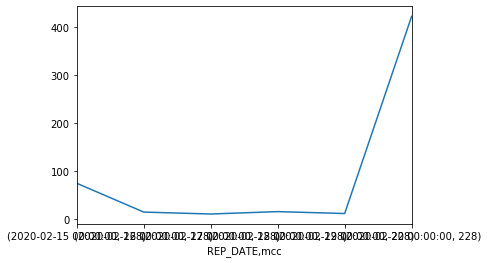

In [22]:
# Generate stat report by country

mcc = 228

df3=df1[df1.index.get_level_values('mcc')==mcc].sort_index(level=['mcc','REP_DATE'])
print(df3,'\n')

df3['charge'].plot()
plt.show()

### By operator

In [23]:
# Find out the operator with the biggest increase

df1=df.groupby(['REP_DATE','mcc','mnc']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc','mnc']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                       std_per   diff
            sum    min        mean    max         std               
mcc mnc                                                             
228 3     552.0   11.0   92.000000  423.0  164.021950   178.3  412.0
262 1     370.0    9.0   61.666667  292.0  112.915307   183.1  283.0
231 6     208.0    4.0   34.666667  180.0   71.222656   205.4  176.0
310 680   984.0   88.0  164.000000  259.0   69.705093    42.5  171.0
234 15   1880.0  215.0  313.333333  378.0   66.886969    21.3  163.0

                        quantity   cost  charge
REP_DATE   mcc mnc                             
2020-02-15 228 3    3.591856e+09   37.0    75.0
2020-02-16 228 3    2.059704e+09    6.0    15.0
2020-02-17 228 3    1.835295e+09    6.0    11.0
2020-02-18 228 3    2.332807e+09    8.0    16.0
2020-02-19 228 3    1.792096e+09    6.0    12.0
2020-02-20 228 3    2.914164e+09  212.0   423.0 



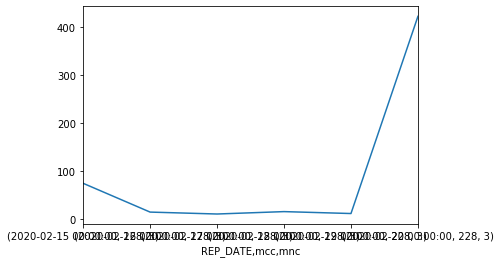

In [24]:
# Generate stat report by country

mcc = 228
mnc = 3

df3=df1[(df1.index.get_level_values('mcc')==mcc) & (df1.index.get_level_values('mnc')==mnc)]\
      .sort_index(level=['mnc','REP_DATE'])
print(df3,'\n')

df3['charge'].plot()
plt.show()

### By customer

In [25]:
# Find out the customer with the biggest increase in Country

df1 = df.groupby(['REP_DATE','mcc','account_id']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity'] = round(df1['quantity'],1)
df1['charge'] = round(df1['charge'],1)
df1['cost'] = round(df1['cost'],1)

df2=df1.groupby(level=['mcc','account_id']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

df2.apply(f, axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                       std_per   diff
                   sum    min        mean    max         std               
mcc account_id                                                             
262 172735       299.0    2.0   59.800000  285.0  125.899563   210.5  283.0
228 172794       285.0    1.0   47.500000  275.0  111.453578   234.6  274.0
234 172844      2569.0  278.0  428.166667  541.0   97.906929    22.9  263.0
231 172794       202.0    4.0   33.666667  177.0   70.230098   208.6  173.0
230 172794       280.0    8.0   46.666667  160.0   58.019537   124.3  152.0

In [26]:
df_352406 = df2.apply(f, axis=1).sort_values(by=['diff','std_per'],ascending=False).reset_index()
df_352406 = df_352406[df_352406.account_id == 172794]
df_352406.head()

mcc account_id charge                                     std_per   diff
                      sum   min       mean    max         std               
1   228     172794  285.0   1.0  47.500000  275.0  111.453578   234.6  274.0
3   231     172794  202.0   4.0  33.666667  177.0   70.230098   208.6  173.0
4   230     172794  280.0   8.0  46.666667  160.0   58.019537   124.3  152.0
8   310     172794  283.0  21.0  47.166667  130.0   41.402496    87.8  109.0
10  250     172794  204.0  15.0  34.000000   85.0   26.275464    77.3   70.0

In [27]:
df_352406.sort_values(by=[('charge', 'sum')], ascending=False).head()

mcc account_id charge                                     std_per   diff
                      sum   min       mean    max         std               
1   228     172794  285.0   1.0  47.500000  275.0  111.453578   234.6  274.0
8   310     172794  283.0  21.0  47.166667  130.0   41.402496    87.8  109.0
4   230     172794  280.0   8.0  46.666667  160.0   58.019537   124.3  152.0
57  520     172794  249.0  32.0  41.500000   46.0    5.357238    12.9   14.0
10  250     172794  204.0  15.0  34.000000   85.0   26.275464    77.3   70.0

In [28]:
# Find out the customer with the biggest increase in Country and Operator

df1=df.groupby(['REP_DATE','mcc','mnc','account_id']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc','mnc','account_id']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

#df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                       std_per  \
                       sum    min        mean    max         std           
mcc mnc account_id                                                         
262 1   172735       298.0    2.0   59.600000  284.0  125.452381   210.5   
228 3   172794       285.0    1.0   47.500000  275.0  111.453578   234.6   
231 6   172794       202.0    4.0   33.666667  177.0   70.230098   208.6   
234 15  172844      1822.0  206.0  303.666667  363.0   64.161255    21.1   
230 2   172794       280.0    8.0   46.666667  160.0   58.019537   124.3   

                     diff  
                           
mcc mnc account_id         
262 1   172735      282.0  
228 3   172794      274.0  
231 6   172794      173.0  
234 15  172844      157.0  
230 2   172794      152.0

,REP_DATE,mcc,mnc,account_id,quantity,cost,charge
0,2020-02-15,228,3,172794,435644530.0,1.0,3.0
1,2020-02-16,228,3,172794,148258625.0,0.0,1.0
2,2020-02-17,228,3,172794,332607615.0,1.0,2.0
3,2020-02-18,228,3,172794,365544369.0,1.0,2.0
4,2020-02-19,228,3,172794,397208390.0,1.0,2.0
5,2020-02-20,228,3,172794,110845090.0,138.0,275.0


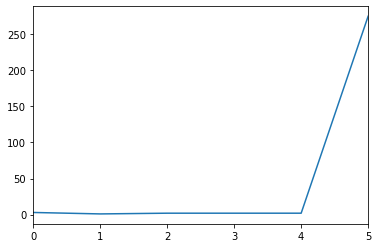

In [29]:
# Generate stat report by country

mcc = 228

account_id = 172794

df3 = df1[(df1.index.get_level_values('mcc')==mcc) & (df1.index.get_level_values('account_id')==account_id)]\
      .sort_index(level=['REP_DATE']).reset_index()
display(df3)

df3['charge'].plot()
plt.show()

,,,,quantity,cost,charge
REP_DATE,mcc,mnc,account_id,,,
2020-02-15,228,3,172794,435644530.0,1.0,3.0
2020-02-16,228,3,172794,148258625.0,0.0,1.0
2020-02-17,228,3,172794,332607615.0,1.0,2.0
2020-02-18,228,3,172794,365544369.0,1.0,2.0
2020-02-19,228,3,172794,397208390.0,1.0,2.0
2020-02-20,228,3,172794,110845090.0,138.0,275.0


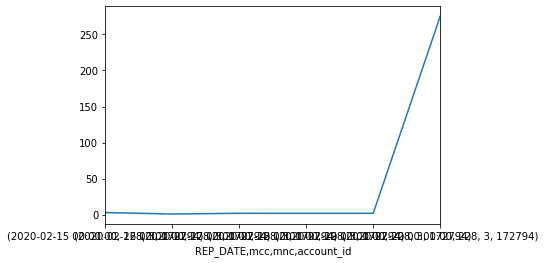

In [30]:
# Generate stat report by country and Operator

mcc = 228
mnc = 3
account_id = 172794

df3=df1[(df1.index.get_level_values('mcc')==mcc) & (df1.index.get_level_values('mnc')==mnc) & (df1.index.get_level_values('account_id')==account_id)]\
      .sort_index(level=['mnc','REP_DATE'])
display(df3)

df3['charge'].plot()
plt.show()

### Report by Subscriber

In [13]:
# Download data from OCS DB

#Connect to OCSDBREP1 (BSS)
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=172.18.11.82;DATABASE=10028;UID=BSS;PWD=iKQVm40AZAmyRaw72LeY')

sql_srt=\
'''
select   
min(u.USAGE_DATE) USAGE_DATE
,u.SUBSCRIBER_ID
,si.IMSI
,si.ICCID
,spn.PHONE_NUMBER
,a.ACCOUNT_NAME
,u.MCC
,u.MNC
,n.NETWORK_NAME
,c.COUNTRY_NAME
,ut.USAGE_TYPE
,sum(uc.CHARGE) Charge
,sum(uc.CHARGE_QUANTITY) Quantity
,u.DEST_PHONE_NUMBER
,u.SESSION_ID
from [10028_usage2019-04].dbo.usage u
inner join [10028_usage2019-04].dbo.USAGE_CHARGES uc on u.USAGE_ID=uc.USAGE_ID
right join [10028].dbo.SUBSCRIBER_IMSIS si on u.SUBSCRIBER_ID = si.SUBSCRIBER_ID and si.END_DATE is null
right join [10028].dbo.SUBSCRIBER_PHONE_NUMBERS spn on u.SUBSCRIBER_ID = spn.SUBSCRIBER_ID and spn.END_DATE is null
inner join [10028].dbo.USAGE_TYPE ut on u.USAGE_TYPE = ut.USAGE_TYPE_ID
right join [10028].dbo.SUBSCRIBERS s on s.SUBSCRIBER_ID = u.SUBSCRIBER_ID
right join [10028].dbo.ACCOUNTS a on a.ACCOUNT_ID = s.ACCOUNT_ID
right join [10028].dbo.RDB_NETWORK_IMSI_PREFIXES net on net.MCC = u.MCC and net.MNC= u.MNC
right join [10028].dbo.RDB_NETWORKS n on net.NETWORK_ID = n.NETWORK_ID
right join [10028].dbo.RDB_COUNTRIES c on c.COUNTRY_ID = n.COUNTRY_ID
where uc.ACCOUNT_ID = 352406 AND u.MCC IN (621, 334)
AND u.USAGE_DATE BETWEEN '2019-04-07 00:00:00' AND '2019-04-09 00:00:00'
group by   u.SUBSCRIBER_ID,
si.IMSI, si.ICCID , spn.PHONE_NUMBER,a.ACCOUNT_NAME,
u.MCC , u.MNC  , n.NETWORK_NAME , c.COUNTRY_NAME, ut.USAGE_TYPE,
u.SESSION_ID , u.DEST_PHONE_NUMBER
order by min(u.USAGE_DATE),u.SUBSCRIBER_ID
'''

df_subscribers = pd.read_sql_query(sql_srt, cnxn, parse_dates={'USAGE_DATE': '%d/%m/%ysort'})
cnxn.close()

df_subscribers.head()

,USAGE_DATE,SUBSCRIBER_ID,IMSI,ICCID,PHONE_NUMBER,ACCOUNT_NAME,MCC,MNC,NETWORK_NAME,COUNTRY_NAME,USAGE_TYPE,Charge,Quantity,DEST_PHONE_NUMBER,SESSION_ID
0,2019-04-07 00:06:24.387,1573717,724390000684331,89553900030006843312,5512974034185,Nextel,334,30,Movistar/Pegaso,Mexico,Data,0.00001,0.00025,None,d0-EPGrh.live.partner.com;1538597561;55767709;...
1,2019-04-07 00:30:25.747,1573501,724390993549584,89553900230061175630,5511957516715,Nextel,334,30,Movistar/Pegaso,Mexico,Data,0.82394,22.88730,None,d1-EPGrh.live.partner.com;1538597562;55793236;...
2,2019-04-07 00:41:49.357,1573668,724390003308068,89553900030033080680,5511975450828,Nextel,334,30,Movistar/Pegaso,Mexico,Data,0.00000,0.00010,None,d1-EPGrh.live.partner.com;1528923558;130278919...
3,2019-04-07 01:07:00.697,1573698,724390996140658,89553910300006736388,5511948346245,Nextel,334,30,Movistar/Pegaso,Mexico,Data,0.19620,5.45000,None,d0-EPGrh.live.partner.com;1528923558;129735267...
4,2019-04-07 01:29:27.200,1573581,724390999264340,89553910300020011834,5511940195221,Nextel,621,20,Airtel/ZAIN/Econet,Nigeria,Incoming Text,0.00000,1.00000,None,18022718-1554593357


In [15]:
df_subscribers['REP_DATE'] = df_subscribers.USAGE_DATE.dt.strftime('%Y-%m-%d')

In [18]:
downloads = 'C:/Users/balob/Downloads'
df_subscribers.groupby(['REP_DATE','IMSI','MCC','USAGE_TYPE','DEST_PHONE_NUMBER'],
                       as_index=False)['Charge','Quantity'].sum().sort_values(by='Charge',
                                                                              ascending=False).head(15)

,REP_DATE,IMSI,MCC,USAGE_TYPE,DEST_PHONE_NUMBER,Charge,Quantity
39,2019-04-07,724390999264338,621,VOIP Outgoing Call,236750531253,65.2740,94.60000
86,2019-04-08,724390999264281,621,VOIP Outgoing Call,236750531296,61.2030,88.70000
134,2019-04-08,724390999264293,621,VOIP Outgoing Call,236750531250,57.3505,83.11667
163,2019-04-08,724390999264339,621,VOIP Outgoing Call,236750531299,55.0045,79.71666
43,2019-04-07,724390999264338,621,VOIP Outgoing Call,236750531299,46.6900,67.66667
96,2019-04-08,724390999264289,621,VOIP Outgoing Call,236750531255,44.8500,65.00000
124,2019-04-08,724390999264292,621,VOIP Outgoing Call,236750531253,42.1130,61.03333
135,2019-04-08,724390999264293,621,VOIP Outgoing Call,236750531296,41.4230,60.03333
25,2019-04-07,724390999264337,621,VOIP Outgoing Call,236750531299,41.4115,60.01667
115,2019-04-08,724390999264291,621,VOIP Outgoing Call,236750531254,41.4000,60.00000


In [22]:
df_subscribers.groupby(['IMSI','MCC','USAGE_TYPE'],
                       as_index=False)['Charge','Quantity'].sum().sort_values(by=['IMSI','Charge'],
                                                                              ascending=False).head(25)

,IMSI,MCC,USAGE_TYPE,Charge,Quantity
45,724390999264340,621,VOIP Outgoing Call,137.54600,199.20000
44,724390999264340,621,Outgoing Call,101.00000,202.00000
43,724390999264340,621,Incoming Text,0.00000,2.00000
42,724390999264339,621,VOIP Outgoing Call,142.91500,206.78334
41,724390999264339,621,Outgoing Call,101.00001,201.99999
40,724390999264339,621,Incoming Text,0.00000,2.00000
39,724390999264338,621,VOIP Outgoing Call,276.29800,400.18335
38,724390999264338,621,Outgoing Call,201.00000,402.00000
37,724390999264338,621,Incoming Text,0.00000,2.00000
36,724390999264337,621,VOIP Outgoing Call,140.08150,203.01667
